# Machine Learning - Identify the Point of Interest in Enron Dataset

Enron is the biggest corporate scandal in thei U.S. history. This report documents how I apply different machine learning algorithms to identify persons of interest in the enron case based on financial and email data made public as a result of the scandal. With the testing data of 146 observations and 21 features, I have completed following steps to identify the best algorithms
- Explored the data and exclude the outliers;
- Excluse variables with large propotion of NAs; Create new features and domenstrate the importance of new features;  Using SelectK to further exclude some unrelated features;
- Apply three models (Guassian Naive Bayes, Support Vector Classifier, and RamdonForest) and apply stratified cross validate 1000 times and grid search to select the models.
- The metrics of precision and recall are applied as the data is largly skewed, and the best performing model is Guassian Naive Bayes

## Key Questions and Answers

- **Data Summary**  The total obervations in the dataset are 146, and the total features are 21. The names of feature are 'salary', 'to_messages', 'deferral_payments', 'total_payments', 'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi', 'restricted_stock_deferred', 'total_stock_value', 'expenses', 'loan_advances', 'from_messages', 'other', 'from_this_person_to_poi', 'poi', 'director_fees', 'deferred_income', 'long_term_incentive', 'email_address', 'from_poi_to_this_person'. There are 18 POIs, 127 non-POIs and one outlier in the dataset. See Part 1


- **Feature Selection** My feature list include 'poi', 'salary', 'total_payments', 'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi', 'total_stock_value', 'expenses', 'deferred_income', 'long_term_incentive', 'from_poi_to_this_person', and 'poi_email_propotion_to'. 

    Comparing witht the origin feature list, the following changes are made:
    - four features are removed due to lack of data, See part;
    - two new features are created to make full use of email variabls: 'poi_email_propotion_from' and 'poi_email_propotion_to' See part ;
    - four features 'from_messages', 'to_messages', 'poi_email_propotion_from', and 'others', since they are not well related to the poi according to the average score in feature selection. See part 2
    
I did the scaling for the features, as I applied Princple Component Analysis methods since many features are highly correlated and PCA can work with the feature correlation and recreate new features that are unrelated to each other.
  

- **Three Models** I end up chose Gaussian Naive Bayes (GNB) algorithm. I applied three algorithm support vector classifer, random forest and GNB. I chose these three algorithm to test for a reason, 
    - GNB is the most popular algorithm for abnormalty detection and work well for the skewed data; 
    - SVC is a very sophiciated methodswith usually very high accuracy, but it is also computationally expensive. The samples number is not that much, we can also reduce dimension through pca, so SVC can apply; 
    - Random forest is a sophicated methods that was improved upon the decision tree. I chose it over decision tree because decsion tree is a greedy methods that only try to achive the best information gain in every node - for dataset like this, since all the components are highly correlated, it might not be a good methods.

Although SVC perform the best in terms of accurancy, GNB did well in precision and recall metrics. Note since there are far less POIs in the dataset than non-POIs, recall and precision matrics are the most appropriate metrics. See part 


- **Cross Validation and Parameter Tunning** Validation is a statistical technique that applies the predictive model to a new independent dataset to confirm the preformance. A model without validation to independent dataset may cause over-fitting (low bias, high variance) which means that the model do not perform as good as in the new independent dataset. Tunning the parameters means finding the parameter or parameter combination that achieve the best performance in the testing dataset of the mode. In this project, I am trying to find the best PCA components for GNB. When the dataset is large we can only do it onece by deviding the dataset into training the testing, generating the model in the training dataset and attaining the performance result in the test dataset. However, if the dataset is small, only doing this once is very bias to the test-training devision. 

    In this example, we use stratified crossvalidation 1000 times to find the panameter. We preforma the cross validation 1000 times randomly based on the stratified methods since 1) the dataset is small; 2) the stratified crossvalidation will rearrange the data as to ensure each fold is a good representative of the whole (our data is highly skewed so it is suitable for this method). I also applied grid search to identify the best performing models in different combinations. I validate my results through sklearn's cross validation gridsearch.
    

- **Selection Metrics** I used percision and recall rate as the metrics. These metrics are useful for the skewed data the data of which have one class that is much larger than the other class. In skewed dataset, accuracy is not the best metric. Taking our dataset for example, we have only 18 POIs out of 145 valid data points. If we predict all the data as non-pois, the accuracy rate is as high as 87.6% but it is not useful. So we use the metrics of percision rate and recall rate. In this case
    - precision rate means out of all the POIs in your prediction, what is the rate of true POIs.
    - recall rate means out of all the true POIs in the testing dataset, using your algorithm, the propotion between number of your corrected predicted POIs and all true POIs.

In the end, the GNB model's recall rate is 0.3333 and its percision rate is 0.36593.


In [1]:
import sys
import pickle
sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data
import pandas as pd
import numpy as np
from finding_k_best_score import split_data, features_importance, imputed_data, find_best_k
from matplotlib import pyplot as plt
plt.style.use('ggplot')
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

## 1. Data Summary

This section summarize the dataset. 
- It explores the number of features and observations. 
- It also conduct some explotary analysis to indentify outliers. 

### 1.1 Features and Obervations of the dataset

The total obervations in the dataset are 146, and the total features are 21. The names of feature are
'salary', 'to_messages', 'deferral_payments', 'total_payments', 'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi', 'restricted_stock_deferred', 'total_stock_value', 'expenses', 'loan_advances', 'from_messages', 'other', 'from_this_person_to_poi', 'poi', 'director_fees', 'deferred_income', 'long_term_incentive', 'email_address', 'from_poi_to_this_person'.

There are 18 POIs and 127 non-POIs.

In [2]:
def counting_obervation(data):
    n=0
    for i in data:
        n+=1
    return n
total_obervation=counting_obervation(data_dict)
print 'The total obervations in the enron dataset is ' + str(total_obervation)

The total obervations in the enron dataset is 146


In [3]:
def counting_data_feature(data):
    m_max=0
    m=0
    for i in data:
        m=len(data[i].keys())
        if m_max>=m:
            continue
        else:
            m_max=m
    return m_max
print 'The total features in the enron dataset is '+ str(counting_data_feature(data_dict))

The total features in the enron dataset is 21


In [4]:
def print_feature_names(data):
    feature_names=[]
    for i in data:
        for j in data[i].keys():
            if j not in feature_names:
                feature_names.append(j)
    return feature_names
feature_names=print_feature_names(data_dict)
print 'The names of features are: '
print print_feature_names(data_dict)


The names of features are: 
['salary', 'to_messages', 'deferral_payments', 'total_payments', 'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi', 'restricted_stock_deferred', 'total_stock_value', 'expenses', 'loan_advances', 'from_messages', 'other', 'from_this_person_to_poi', 'poi', 'director_fees', 'deferred_income', 'long_term_incentive', 'email_address', 'from_poi_to_this_person']


In [5]:
def counting_poi(data):
    x=0
    for i in data:
        if data[i]['poi']==1:
            x+=1
    return x
NumberofPoi=counting_poi(data_dict)
def counting_non_poi(data):
    x=0
    for i in data:
        if data[i]['poi']==0:
            x+=1
    return x
NumberofNonePoi=counting_non_poi(data_dict)
print "The number of poi in this enron dataset is "+ str(NumberofPoi)+"."
print "The number of non-poi in this dataset is "+str(NumberofNonePoi)+"."


The number of poi in this enron dataset is 18.
The number of non-poi in this dataset is 128.


### Detecting the outliers

In this section, we examine the distributions of some key variables and detect an outlier named "Total" and removed it.

In [6]:
#put enron_data in pd dataframe and change value from string to numeric
enron_data=pd.DataFrame(data_dict)
enron_data=enron_data.T
def change_to_numeric(dataframe, variable):
    return pd.to_numeric(dataframe[variable], errors='coerce')
for i in feature_names:
    if i!='email_address' and i!='poi' and i!='other':
        enron_data[i]=change_to_numeric(enron_data, i)

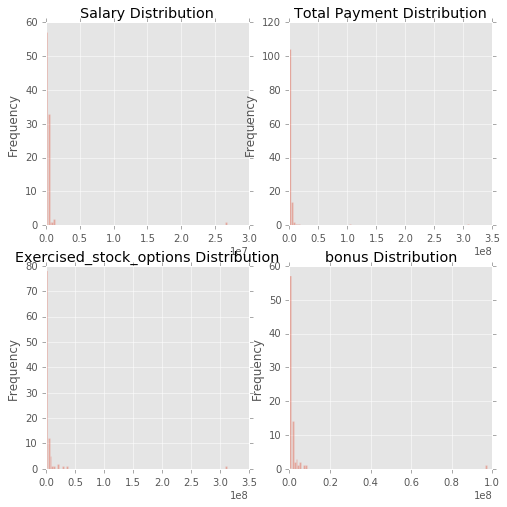

In [7]:
%matplotlib inline
from matplotlib.pyplot import subplot
plt.figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')
subplot(221)
enron_data['salary'].plot.hist(alpha=0.4, bins=100)
plt.title('Salary Distribution')
subplot(222)
enron_data['total_payments'].plot.hist(alpha=0.4, bins=100)
plt.title('Total Payment Distribution')
subplot(223)
enron_data['exercised_stock_options'].plot.hist(alpha=0.4, bins=100)
plt.title('Exercised_stock_options Distribution')
subplot(224)
enron_data['bonus'].plot.hist(alpha=0.4, bins=100)
plt.title('bonus Distribution')

From the plots above, we can see there is a value that is much larger than any of other values in the dataset. To idenfity the name of the related values, we perform the following data detection program and found that the obervation name is 'TOTAL'. 
we decide to remove this outlier as it is a input mistake.

In [8]:
salary_outlier=max(enron_data['salary'])
def find_outlier(dataset, variable_name, value):
    observation_name=''
    for i in range(len(dataset.keys())):
        if dataset[dataset.keys()[i]][variable_name]==value:
            observation_name=dataset.keys()[i]
    return observation_name
outlier_name=find_outlier(data_dict, 'salary', salary_outlier)
print 'The name of observation of the outlier is ' + outlier_name +"."

The name of observation of the outlier is TOTAL.


In [9]:
#remove the outlier
data_dict.pop('TOTAL', 0)
#remove the outlier in the pd.DataFrame
enron_data=enron_data[enron_data.index!='TOTAL']

We replot the histogram of some features and we found the distribution is within normal range

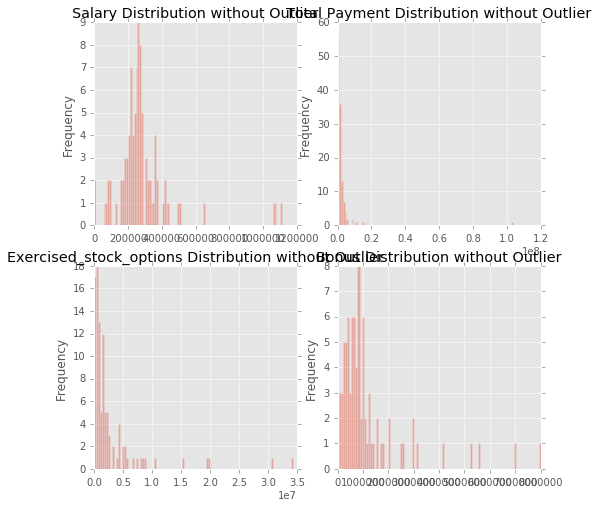

In [10]:
%matplotlib inline
plt.figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')
subplot(221)
enron_data['salary'].plot.hist(alpha=0.4, bins=100)
plt.title('Salary Distribution without Outlier')
subplot(222)
enron_data['total_payments'].plot.hist(alpha=0.4, bins=100)
plt.title('Total Payment Distribution without Outlier')
subplot(223)
enron_data['exercised_stock_options'].plot.hist(alpha=0.4, bins=100)
plt.title('Exercised_stock_options Distribution without Outlier')
subplot(224)
enron_data['bonus'].plot.hist(alpha=0.4, bins=100)
plt.title('Bonus Distribution without Outlier')

In [11]:
potential_outlier_total_payment=max(enron_data['total_payments'])
potential_outlier_name_total_payement=find_outlier(data_dict, 'total_payments', potential_outlier_total_payment)
print potential_outlier_name_total_payement

LAY KENNETH L


Even though there seems to have an outlier of total payment after remove the 'total', after examination, it is not an outlier, but represent the high amount of payments received by the company president.

## 2. Feature Selection and New Features

The features in the dataset are 'salary', 'to_messages', 'total_payments', 'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi', 'total_stock_value', 'expenses','from_messages', 'from_this_person_to_poi','from_poi_to_this_person', 'deferred_income', and 'deferral_payments' 'deferral_payments', 'director_fees', 'loan_advances', 'restricted_stock_deferred', 'poi','email_address.

This section describe the feature selection process, conducted the explortary analysis on existing features and also created new features. In the end it finalize the features into the models. 

### 2.1 First Round Selection: counting the NAs for features
In the analysis above, we notice there are quite a lot of missing values in the dataset. To select variables that are relevant and useful, we tend to select variable with relatively complete data. On the other hand, considering this dataset is skewed, the detection learning would need more valid data on the smaller class- the poi class. So our selection criterion based on number of NAs examine two parts:
- Condition 1: whether more than half of poi=1 class' value for this variables are not NAN;
- Condition 2: whether more than half of obervations' value for this variable are not NAN;

We tend to keep variables that meet both condition. However, if a variable meets condition 1 but not 2, we might consider keeping it depending on the number of missing values in condition 2.

In [13]:
null_percentage=enron_data.isnull().sum()/total_obervation
null_percentage_50=null_percentage<0.5
null_percentage_poi=enron_data[enron_data['poi']==1].isnull().sum()/NumberofPoi
null_percentage_poi_50=null_percentage_poi<0.5
Variable_NA_Selection=pd.DataFrame({
        "Null_Percentage_of_Poi": null_percentage_poi,
                'Whether_Null_Percentage_of_Poi_larger_than_50': null_percentage_poi_50,
        "Null_Percentage": null_percentage,  
                'Whether_Null_Percentage_larger_than_50': null_percentage_50,
                }, index=feature_names)
Variable_NA_Selection.sort_values('Null_Percentage_of_Poi')

,Null_Percentage,Null_Percentage_of_Poi,Whether_Null_Percentage_larger_than_50,Whether_Null_Percentage_of_Poi_larger_than_50
expenses,0.349315,0.000000,True,True
poi,0.000000,0.000000,True,True
other,0.000000,0.000000,True,True
total_payments,0.143836,0.000000,True,True
email_address,0.000000,0.000000,True,True
total_stock_value,0.136986,0.000000,True,True
salary,0.349315,0.055556,True,True
restricted_stock,0.246575,0.055556,True,True
bonus,0.438356,0.111111,True,True
shared_receipt_with_poi,0.404110,0.222222,True,True


Discussion, we can see only four variables ['deferral_payments', 'loan_advances', 'restricted_stock_deferred', 'director_fees'] did not meet both condition. The variable email is not providing much information either given it is only related to person name. 

Two variables 'deferred_income' and 'deferral_payments' meet the first condition and the percetage of null is only slightly larger than 50%. To maintain more information, I keep both variables too.
The final variables are following

In [14]:
excluded_features=['deferral_payments', 'director_fees', 
                   'loan_advances', 'restricted_stock_deferred', 
                    'poi','email_address']
feature_list=['poi']
for i in feature_names:
    if i not in excluded_features:
        feature_list.append(i)
feature_list

['poi',
 'salary',
 'to_messages',
 'total_payments',
 'exercised_stock_options',
 'bonus',
 'restricted_stock',
 'shared_receipt_with_poi',
 'total_stock_value',
 'expenses',
 'from_messages',
 'other',
 'from_this_person_to_poi',
 'deferred_income',
 'long_term_incentive',
 'from_poi_to_this_person']

### 2.2 Access the Features

#### General Exploration

From the data.describe() and matrics analysis below, we can summarize some features of the dataset below
- Most of variables' distribution are rightly skewed, we might want to scale log the value to get better performance;
- Some variables displays very clear correlation with others unsurprisingly. e.g. salary, bonus, restricted_stock, total_stock_values, and total_payments are highly correlated. These variables along with shared_receitpt_with_poi did vary by poi;
- Some variables did not display very significant difference by the poi variable, such as messages_from, messages_to and expenses.

In [15]:

enron_data=enron_data[['poi','salary','total_payments', 'exercised_stock_options', 
                              'bonus', 'restricted_stock', 'shared_receipt_with_poi', 
                              'total_stock_value', 'expenses','from_messages', 
                              'from_this_person_to_poi','from_poi_to_this_person','to_messages', 
                             'deferred_income','deferral_payments']]
enron_data.describe(include='all')

/Users/heshuangzeng/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,poi,salary,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,total_stock_value,expenses,from_messages,from_this_person_to_poi,from_poi_to_this_person,to_messages,deferred_income,deferral_payments
count,145,9.400000e+01,1.240000e+02,1.010000e+02,8.100000e+01,1.090000e+02,86.000000,1.250000e+02,94.000000,86.000000,86.000000,86.000000,86.000000,4.800000e+01,3.800000e+01
unique,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2.840875e+05,2.623421e+06,2.959559e+06,1.201773e+06,1.147424e+06,1176.465116,3.352073e+06,54192.010638,608.790698,41.232558,64.895349,2073.860465,-5.810498e+05,8.416025e+05
std,NaN,1.771311e+05,9.488106e+06,5.499450e+06,1.441679e+06,2.249770e+06,1178.317641,6.532883e+06,46108.377454,1841.033949,100.073111,86.979244,2582.700981,9.420764e+05,1.289323e+06
min,NaN,4.770000e+02,1.480000e+02,3.285000e+03,7.000000e+04,-2.604490e+06,2.000000,-4.409300e+04,148.000000,12.000000,0.000000,0.000000,57.000000,-3.504386e+06,-1.025000e+05
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11a0b8990>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x124124350>]], dtype=object)

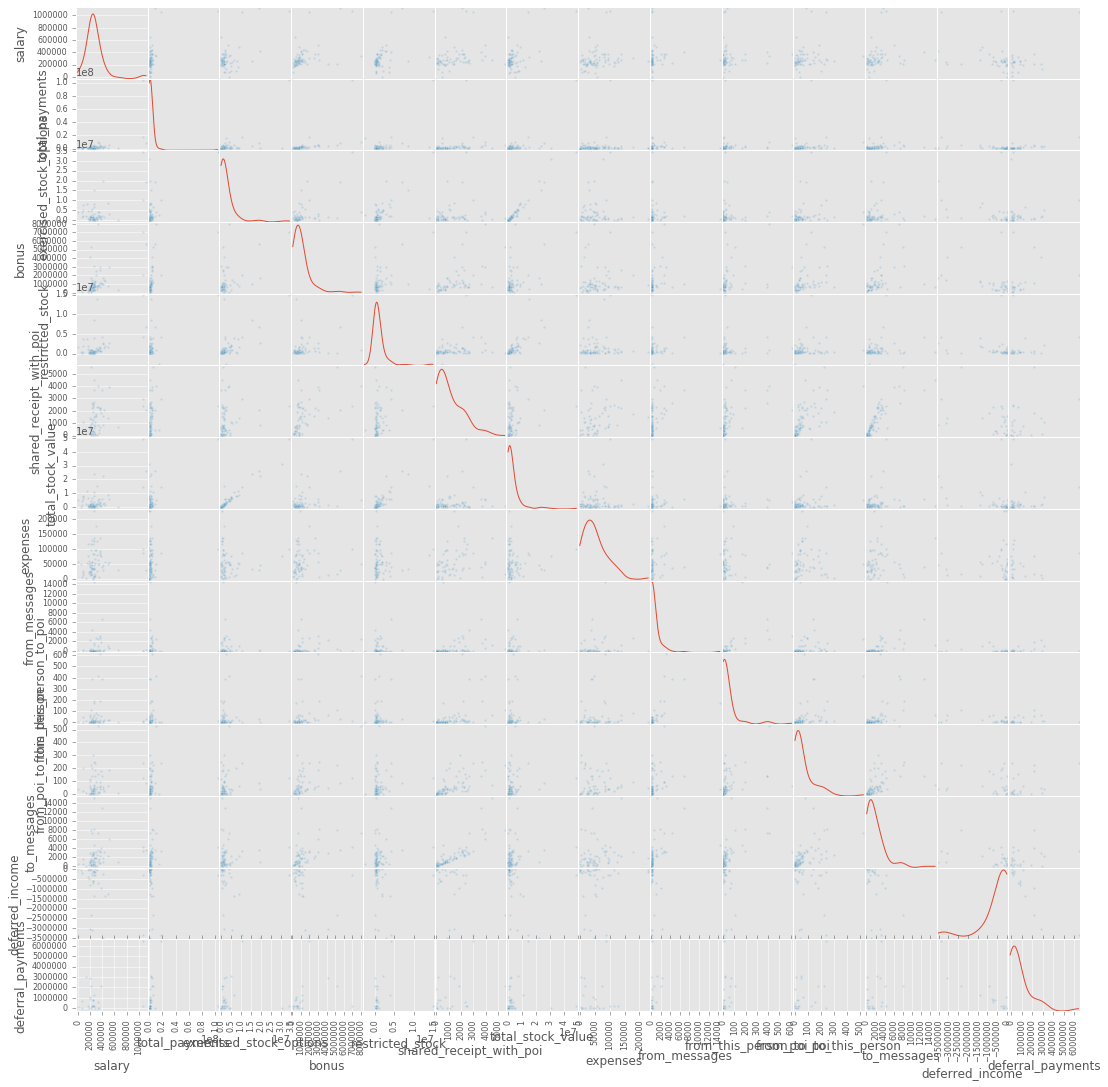

In [20]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix(enron_data, alpha=0.2, figsize=(18, 18), diagonal='kde')

#### Feature Importance without new features

In this part, we conducted some explortary analysis and data visualization. The relationship between compensation-related variables like salary, bonus, restricted_stock and poi is quite clear. However, even though we have some good information related to emails, we did not identify very clear patten on emails-related information and poi. I further conducted the univariate feature selection and confirm the email-related variables are not significantly related to poi.

(0, 5000000)

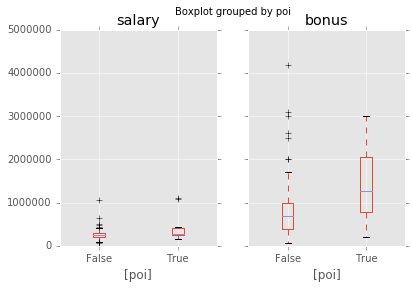

In [16]:
enron_data.boxplot(column=['salary', 'bonus'], by=['poi'])
plt.ylim([0,5000000])

(0, 10000000)

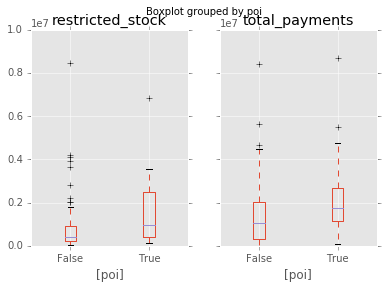

In [21]:
enron_data.boxplot(column=['restricted_stock', 'total_payments'], by=['poi'])
plt.ylim([0,10000000])

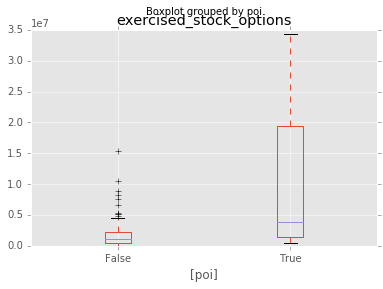

In [22]:
enron_data.boxplot(column=['exercised_stock_options'], by=['poi'])

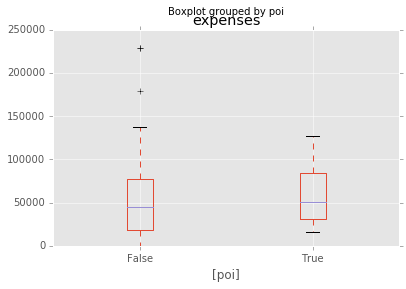

In [23]:
enron_data.boxplot(column=['expenses'], by=['poi'])

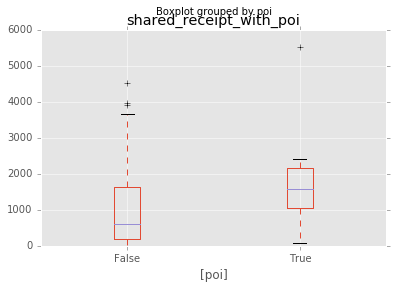

In [24]:
enron_data.boxplot(column=['shared_receipt_with_poi'], by=['poi'])

(0, 300)

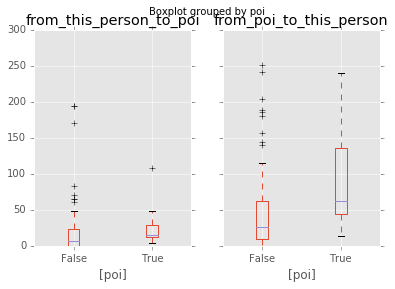

In [25]:
enron_data.boxplot(column=['from_this_person_to_poi', 'from_poi_to_this_person'], by=['poi'])
plt.ylim([0,300])

(0, 500)

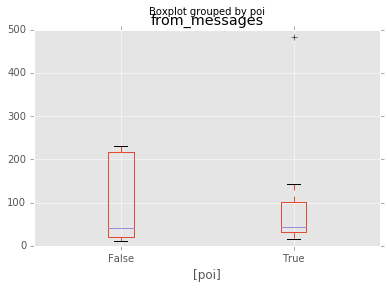

In [26]:
enron_data.boxplot(column=['from_messages'], by=['poi'])
plt.ylim([0,500])

(0, 5000)

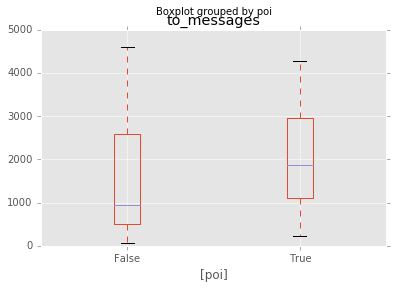

In [27]:
enron_data.boxplot(column=['to_messages'], by=['poi'])
plt.ylim([0,5000])

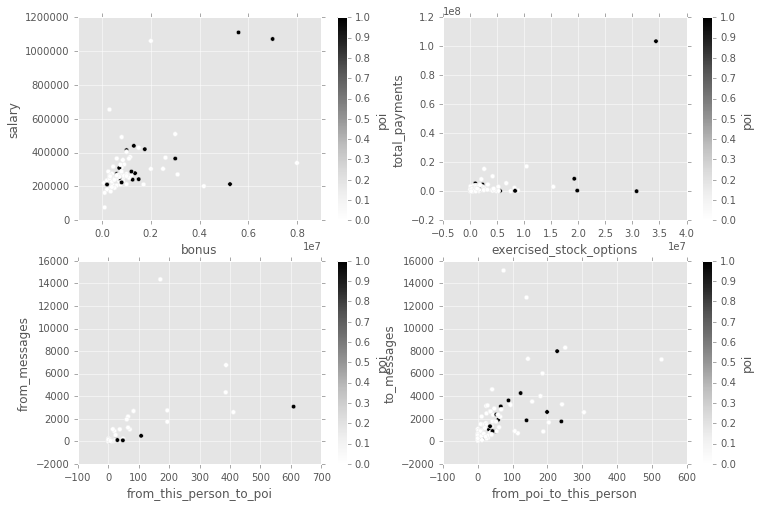

In [17]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(8)
fig.set_figwidth(12)
enron_data.plot(ax=axes[0,0], kind='scatter', x='bonus', y='salary', c='poi')
enron_data.plot(ax=axes[0,1], kind='scatter', x='exercised_stock_options', y='total_payments', c='poi')
enron_data.plot(ax=axes[1,0], kind='scatter', x='from_this_person_to_poi', y='from_messages', c='poi')
enron_data.plot(ax=axes[1,1], kind='scatter', x='from_poi_to_this_person', y='to_messages', c='poi')

From the figure above, we can see there is correlation between some variables. On the other hand, based on messages_from, messages_to and the messages related to poi, it might be worth creating some new variables indicate the relationship between poi-related messages and total message.

In [18]:
from finding_k_best_score import split_data, features_importance, imputed_data, find_best_k
my_dataset=data_dict
random_states=range(1,200)
find_best_k(my_dataset, feature_list, random_states)

,Pvalues,Scores
salary,0.005155,13.284409
total_stock_value,0.006161,17.296155
exercised_stock_options,0.008768,17.464168
bonus,0.011414,15.666368
deferred_income,0.040157,9.118673
long_term_incentive,0.043339,8.032848
shared_receipt_with_poi,0.052719,6.431901
restricted_stock,0.058027,7.753332
expenses,0.071550,4.434500
total_payments,0.099499,6.302344


### 2.3 Create New Features and Reaccessment

Built upon last section, we try to find ways to utilize the email information, as a result, we create two variables that indicate the propotion of emails_sent_to_poi in total_email_sent and the proportion of emails_received_from_poi in total_email_received. I reconducted the univariate feature selection and confirm the significance of the new variables. 

We created two variables called propotion_messages_from_poi, and propotion_messages_to_poi which are the ratio between from_this_person_to_poi and from_messages, and from_poi_to_this_person and to_messages respectively.

In [19]:
enron_data['propotion_messages_from_poi']=enron_data['from_poi_to_this_person']/enron_data['to_messages']
enron_data['propotion_messages_to_poi']=enron_data['from_this_person_to_poi']/enron_data['from_messages']

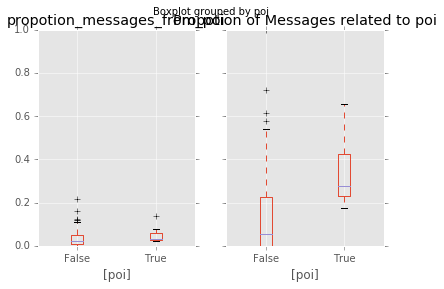

In [20]:
enron_data.boxplot(column=['propotion_messages_from_poi', 'propotion_messages_to_poi'], by=['poi'])
plt.title('Propotion of Messages related to poi')

In [21]:
for i in data_dict:
    data_dict[i]['poi_email_propotion_from']=float(data_dict[i]['from_poi_to_this_person'])/float(data_dict[i]['to_messages'])
    data_dict[i]['poi_email_propotion_to']=float(data_dict[i]['from_this_person_to_poi'])/float(data_dict[i]['from_messages'])

In [22]:
feature_list_update=['poi','salary','to_messages','total_payments','exercised_stock_options',
 'bonus','restricted_stock','shared_receipt_with_poi','total_stock_value','expenses',
 'from_messages','other','from_this_person_to_poi','deferred_income',
 'long_term_incentive','from_poi_to_this_person','poi_email_propotion_from','poi_email_propotion_to']
find_best_k(my_dataset, feature_list_update, random_states)

,Pvalues,Scores
salary,0.004608,13.833606
total_stock_value,0.005385,17.909529
exercised_stock_options,0.007058,18.379514
bonus,0.007104,16.340773
poi_email_propotion_to,0.009619,10.679826
shared_receipt_with_poi,0.040950,6.686737
long_term_incentive,0.043016,8.966839
deferred_income,0.049412,9.026110
restricted_stock,0.051345,7.521895
expenses,0.065343,4.557352


Here we see the email-information-related feature poi_email_propotion_to moving up a bit. However 'poi_email_propotion_from' did not show much correlation with the predictor. 
Comparing two feature selection results, we found variable 'from_message', 'to_messages', ,  'from_this_person_to_poi' from have very large p value. We remove these this feature from this.

**Note** In this section, I am trying to use hunderds of iterations to make a good selection of best K (If we only use one split to select, there would be too much bias). Please see find_best_k.py in the folder. 

In [23]:
features_to_remove=['from_messages', 'other', 'from_this_person_to_poi', 'to_messages', 'poi_email_propotion_from']
feature_list_update=['poi','salary','to_messages','total_payments','exercised_stock_options',
 'bonus','restricted_stock','shared_receipt_with_poi','total_stock_value','expenses',
 'from_messages','other','from_this_person_to_poi','deferred_income',
 'long_term_incentive','from_poi_to_this_person','poi_email_propotion_from','poi_email_propotion_to']
for i in features_to_remove:
    feature_list_update.remove(i)
print feature_list_update

['poi', 'salary', 'total_payments', 'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi', 'total_stock_value', 'expenses', 'deferred_income', 'long_term_incentive', 'from_poi_to_this_person', 'poi_email_propotion_to']


## 3. Model Selection

There are several classification models avaiable. In this section, I tested three classifers: SVM(linear), Randomforest, and Gaussian NaiveBayes. 

For the new features 'poi_email_propotion_to', there are some missing data, I used imputed methods to replace the missing data with mean. Since I want to apply PCA, I scaler all the features in the feature list. 

Since many features are correlated, I would like to perform pca for GNB classifier since the assumption is all the factors are unrelated. PCA creats a set of unrelated new feature components that can catch the variablities of the predictor. I also perform PCA for SVM classifier since it is computationally costly and dimension reduction will save the compuation. For Random Forest, I did not scale the variables and only applied select best K.

I apply stratified cross validation 1000 times and grid search to find the best parameter for each models. Since the dataset is skewed and small, stratified cross validation is the best option. Grid search is also a handy method dealing with multiple parameter combination.

In [24]:
my_dataset=data_dict
data=featureFormat(my_dataset, feature_list_update, sort_keys = True)
labels, features= targetFeatureSplit(data)

In [25]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.feature_selection import SelectKBest
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn import metrics
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn import preprocessing
from tester import test_classifier

### Gaussian Naive Bayes Model

In [26]:
steps_gnb = [('pre_pro', Imputer(missing_values='NaN', strategy='mean', axis=0)),
             ('feature_scaling', StandardScaler()),
                ('reduce_dim', PCA()), 
                ('GNB', GaussianNB())]
GNB = Pipeline(steps_gnb)
cv=StratifiedShuffleSplit(labels, 1000)
params_gnb = dict(reduce_dim__n_components=[5,6,7,9, 10, 11])
clf_gnb = GridSearchCV(GNB, param_grid=params_gnb, cv=cv, scoring='f1')
clf_gnb.fit(features, labels)

/Users/heshuangzeng/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


GridSearchCV(cv=StratifiedShuffleSplit(labels=[ 0.  0. ...,  1.  0.], n_iter=200, test_size=0.1, random_state=None),
       error_score='raise',
       estimator=Pipeline(steps=[('pre_pro', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('feature_scaling', StandardScaler(copy=True, with_mean=True, with_std=True)), ('reduce_dim', PCA(copy=True, n_components=None, whiten=False)), ('GNB', GaussianNB())]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'reduce_dim__n_components': [5, 6, 7, 9, 10, 11]},
       pre_dispatch='2*n_jobs', refit=True, scoring='f1', verbose=0)

In [27]:
print clf_gnb.best_estimator_

Pipeline(steps=[('pre_pro', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('feature_scaling', StandardScaler(copy=True, with_mean=True, with_std=True)), ('reduce_dim', PCA(copy=True, n_components=5, whiten=False)), ('GNB', GaussianNB())])


In [28]:
clf_gnb=clf_gnb.best_estimator_

### Ramdon Forest Model

In [29]:
steps_rf = [('pre_pro', preprocessing.Imputer(missing_values='NaN', strategy='mean', axis=0)),
                ('sek', SelectKBest()),
                 ('rf', RandomForestClassifier())]
rf = Pipeline(steps_rf)
cv=StratifiedShuffleSplit(labels, 200)
params_rf = dict(sek__k=range(4,10))
clf_rf = GridSearchCV(rf, param_grid=params_rf, scoring='f1', cv=cv)
clf_rf.fit(features, labels)

GridSearchCV(cv=StratifiedShuffleSplit(labels=[ 0.  0. ...,  1.  0.], n_iter=200, test_size=0.1, random_state=None),
       error_score='raise',
       estimator=Pipeline(steps=[('pre_pro', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('sek', SelectKBest(k=10, score_func=<function f_classif at 0x1135afa28>)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='a...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'sek__k': [4, 5, 6, 7, 8, 9]}, pre_dispatch='2*n_jobs',
       refit=True, scoring='f1', verbose=0)

In [30]:
print clf_rf.best_estimator_

Pipeline(steps=[('pre_pro', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('sek', SelectKBest(k=5, score_func=<function f_classif at 0x1135afa28>)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='au...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])


In [31]:
clf_rf=clf_rf.best_estimator_

### Support Vector Machine Model

In [56]:
steps_svc = [('pre_pro', preprocessing.Imputer(missing_values='NaN', strategy='mean', axis=0)),
                ('sek', SelectKBest()),
                ('feature_scaling', StandardScaler()),     
                 ('reduce_dim', PCA()), 
                 ('svm', SVC(kernel='linear'))]
svc = Pipeline(steps_svc)
cv=StratifiedShuffleSplit(labels, 200)
params_svc = dict(reduce_dim__n_components=[5,6,7,8,9], svm__C=[1, 10, 100])
clf_svc = GridSearchCV(svc, param_grid=params_svc, cv=cv, scoring='recall')
clf_svc.fit(features, labels)

GridSearchCV(cv=StratifiedShuffleSplit(labels=[ 0.  0. ...,  1.  0.], n_iter=200, test_size=0.1, random_state=None),
       error_score='raise',
       estimator=Pipeline(steps=[('pre_pro', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('sek', SelectKBest(k=10, score_func=<function f_classif at 0x1135afa28>)), ('feature_scaling', StandardScaler(copy=True, with_mean=True, with_std=True)), ('reduce_dim', PCA(copy=True, n_components=None...,
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'svm__C': [1, 10, 100], 'reduce_dim__n_components': [5, 6, 7, 8, 9]},
       pre_dispatch='2*n_jobs', refit=True, scoring='recall', verbose=0)

In [57]:
print clf_svc.best_estimator_

Pipeline(steps=[('pre_pro', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('sek', SelectKBest(k=10, score_func=<function f_classif at 0x1135afa28>)), ('feature_scaling', StandardScaler(copy=True, with_mean=True, with_std=True)), ('reduce_dim', PCA(copy=True, n_components=9, w...,
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])


In [58]:
clf_svc=clf_svc.best_estimator_

## 4. Model Evaluation

After testing, we compares the results of three models and using F1 score metrics and chose Gaussian Naive Bayes model. Note GNB is not the best performing model in terms of accuracy, but it did very well to maintain a high recall rate and precision rate.

In [33]:
test_classifier(clf_gnb, my_dataset, feature_list_update, folds=1000)

Pipeline(steps=[('pre_pro', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('feature_scaling', StandardScaler(copy=True, with_mean=True, with_std=True)), ('reduce_dim', PCA(copy=True, n_components=5, whiten=False)), ('GNB', GaussianNB())])
	Accuracy: 0.83413	Precision: 0.36593	Recall: 0.33300	F1: 0.34869	F2: 0.33910
	Total predictions: 15000	True positives:  666	False positives: 1154	False negatives: 1334	True negatives: 11846



In [34]:
test_classifier(clf_rf, my_dataset, feature_list_update, folds = 1000)

Pipeline(steps=[('pre_pro', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('sek', SelectKBest(k=5, score_func=<function f_classif at 0x1135afa28>)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='au...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])
	Accuracy: 0.85620	Precision: 0.41229	Recall: 0.18450	F1: 0.25492	F2: 0.20742
	Total predictions: 15000	True positives:  369	False positives:  526	False negatives: 1631	True negatives: 12474



In [59]:
test_classifier(clf_svc, my_dataset, feature_list_update, folds = 1000)

Pipeline(steps=[('pre_pro', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('sek', SelectKBest(k=10, score_func=<function f_classif at 0x1135afa28>)), ('feature_scaling', StandardScaler(copy=True, with_mean=True, with_std=True)), ('reduce_dim', PCA(copy=True, n_components=9, w...,
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])
	Accuracy: 0.86247	Precision: 0.44688	Recall: 0.13250	F1: 0.20440	F2: 0.15420
	Total predictions: 15000	True positives:  265	False positives:  328	False negatives: 1735	True negatives: 12672



In [60]:

model_comparison=pd.DataFrame(
    {'GNB': {'Accuracy': 0.83413, 'Precision': 0.36593, 'Recall': 0.33300, 'F1': 0.25492}, 
'RF': {'Accuracy': 0.85620,  'Precision': 0.41229, 'Recall': 0.18450, 'F1': 0.15221},
'SVC': {'Accuracy': 0.86207, 'Precision': 0.44688, 'Recall': 0.13250, 'F1': 0.21000}})

model_comparison.T.sort_values('F1')



,Accuracy,F1,Precision,Recall
RF,0.85620,0.15221,0.41229,0.1845
SVC,0.86207,0.21000,0.44688,0.1325
GNB,0.83413,0.25492,0.36593,0.3330
